# Project 6: Iterative Closest Point

Due Date: Monday, April 20, 2020 @ 11:59 P.M.

Student Name: Collin Avidano

In this project, you will implement the ICP algorithm and use it alongside GTSAM to perform simultaneous localization & mapping (SLAM) on Lidar scans. This is an individual assignment, and you will be held by the Georgia Tech honor code to finish it by yourself. Collaboration at the white board level is allowed.

#Setup

In this section, we'll install pip packages, define helper functions, and download the dataset.

In [ ]:
# TODO: Comment this line after running this code cell
#!pip install -q gdown pyntcloud plotly gtsam

     |████████████████████████████████| 348kB 3.3MB/s 
     |████████████████████████████████| 7.8MB 11.0MB/s 


In [ ]:
import os
import math
import gtsam
import numpy as np
import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot
from sklearn.neighbors import NearestNeighbors

#!gdown https://drive.google.com/uc?id=1r-A32_tZXwSTMxnemvQrDY7CCpXNG0Ng
#!unzip -qo data.zip

from data.helpers import *

LIDAR_FPATH = "data/lidar/"

scans_fnames = []
for file in sorted(os.listdir(LIDAR_FPATH)):
    scans_fnames.append(os.path.join(LIDAR_FPATH, file))

Downloading...
From: https://drive.google.com/uc?id=1r-A32_tZXwSTMxnemvQrDY7CCpXNG0Ng
To: /content/data.zip
195MB [00:01, 184MB/s]


Next, load in the datset. This cell finds filenames for all of the point cloud files (.ply) in the dataset.

# Visualization

In this section, we'll become aquainted with the dataset.

This dataset is composed of 180 Lidar scans (.ply files) captured by Argo AI, a self-driving car company based in Pittsburgh, PA. These scans were captured over 18 seconds by one of their cars in Miami, which was likely equiped with a Lidar sensor similar to this [one](https://velodynelidar.com/products/hdl-64e/). This 30 second video clip from the car's front camera gives a good intuition of what happens: https://youtu.be/FUDRK_0iEKA. The first 12 seconds, where the car is stationary, are not part of our dataset.

It's night-time and the car starts at an offset T-intersection. It waits for a car, three bicyclists, and another car to pass (12 seconds that are not part of our dataset). Then it makes a left turn onto NW 2nd Ave and traveling down the street (18 seconds that is our dataset).

In this cell, we read in the first Lidar scan and visualizes it at full resolution (~88,000 points). Use the plot menu to zoom, pan, and rotate around the scene. Then, change the index on `scans_fnames` to see some of the later frames.

In [ ]:
visualize_clouds(read_ply(scans_fnames[0]), show_grid_lines=True)

Output hidden; open in https://colab.research.google.com to view.

This cell reads in the first 20 Lidar scans and visualizes them (as an animation) at a reduced resolution. Due to browser limitations, any additional frames after the first 5 must be rendered at reduced resolutions. Play around with the number of frames loaded by modifying the index on `scans_fnames`.

In [ ]:
# the more frames visualized, the lower the resolution of each cloud
clouds_subset = read_ply(*scans_fnames[:20], as_animation=True)

visualize_clouds_animation(clouds_subset)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# visualizing the entire sequence at a low resolution
clouds_all = read_ply(*scans_fnames, as_animation=True)

visualize_clouds_animation(clouds_all)

Output hidden; open in https://colab.research.google.com to view.

# Iterative Closest Point

In this section, we'll load in two point clouds and implement the five steps of ICP to align them.



In [ ]:
# we'll read in the first and sixth clouds
clouda = read_ply(scans_fnames[0])[0]
cloudb = read_ply(scans_fnames[5])[0]

visualize_clouds([clouda, cloudb], show_grid_lines=True)

Output hidden; open in https://colab.research.google.com to view.

Let's take a moment to talk about the shape of these clouds. Each cloud is a numpy array of shape (3, n), where n is the number of point in the cloud. The first dimension is 3 because each point has an x, y, and z component. Therefore, cloud[0] would be an array of length n that contains the x component of each point in the cloud.

There are five steps to ICP:
1.   Initial transformation
2.   Transform cloud
3.   Assign closest point pairs
4.   Estimate transformation
5.   Repeat steps 2-4 for maximum number of iterations or change is very small

Let's begin with Step 1: the initial tranformation (no code to implement)

The initial transform will be an input to your ICP algorithm, so there is no code to implement here. Below, we describe some methods through which the initial transform is found.

As you can see in the visualization of the two clouds, the two clouds are nearly identical. This makes sense since the cloudb was captured 0.1 seconds after clouda. By hovering over the landmarks we expect to stay stationary on the street (such as parked cars along the street), we can see that cloudb is rotated and translated some x amount from clouda. For someone running icp on two clouds, they could use this guess-timate. Here's how this is done at a self-driving company. Tracking landmarks to compose the initial guess is common. Argo AI can (and does) write CNNs to detect and track landmarks (i.e. street signs, buildings, parked cars), and then computes the distance between stationary landmarks.

Another method could be using kinematic information of the car. The car know's its heading, velocity, and acceleration, allowing us to use the elapsed time to estimate our transform.

Even another method could be centroid of the point clouds. By computing translation between centroida and centroidb, we have half of a guess at the initial transform.

Ultimately, the cloud pairs that are being ICP-ed together are captured less than a second apart. It might be possible then to just use the identity transform as the initial guess.

**TODO** [8 points]

Step 2: Transform cloud

Given an input cloud, apply the gtsam.Pose3 transform on each point in the cloud. The recommended approach is convert each point in the point cloud into homogeneous points and apply a homogeneous transformation to each point. Using numpy, this can be done with no loops.

Hint: Look at gtsam.Pose3's documentation for the `matrix()` function to get the homogeneous transform.

In [ ]:
def transform_cloud(bTa, clouda):
    """Transforms each point in a cloud
    given a gtsam.Pose3 transform.

    Args:
        bTa (gtsam.Pose3): the transform used on each pt in the cloud
        clouda (ndarray):  the cloud being transformed

    Ret:
        ndarray: the transformed cloud
    """

    # bTa world to a transform
    # print(bTa.matrix())
    
    clouda_m = np.concatenate(( clouda, np.full((1, clouda.shape[1]), 1) )) 
    transformeda = np.matmul(bTa.matrix(), clouda_m)
    carta = transformeda[0:3,:] / transformeda[3,:] 
    return carta 

**TODO** [8 points]

Step 3: Assign closest point pairs

For each point in clouda, find the closest (euclidean-wise) point in cloudb and form a pair. Return a cloud shaped like clouda that has been rearranged to form closest pairs index-wise between points in clouda and points in rearranged cloudb.

Note: we have imported scipy's `NearestNeighbors`. Look at the documentation and use it in your implementation.

In [ ]:
def assign_closest_pairs(clouda, cloudb):
    """Returns a rearranged version of cloudb,
    where index-wise corresponding points in
    clouda and rearranged cloudb are closest
    euclidean distance.

    Note: Don't modify clouda or cloudb here.

    Args:
        clouda (ndarray): point cloud A
        cloudb (ndarray): point cloud B

    Ret:
        ndarray: rearranged cloudb
    """
    # Can I have a hug. My stress is just really bad ever since this all began. Like I know its that way for everyone thought so I hope you all are doing well.

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(cloudb.T) # keep it aligned with the example code from docs where a point is a row
    distances, indicies = neigh.kneighbors(clouda.T)
    
    cloudb_mod = cloudb[:, indicies.flatten()] # use the rearranged cloudb indicies (2nd column of the indicies) coming out of kneighbors to access those columns in the original cloudb forming a reorganized version
   
    return cloudb_mod

Step 4: Estimate transform (This step is given by the TAs.)

Given clouda and cloudb, this function will tell you the transform to apply on clouda to get closer to cloudb.

In [ ]:
def estimate_transform(clouda, cloudb):
    """Estimate the transform from clouda to
    cloudb. Returns a gtsam.Pose3 object.

    Args:
        clouda (ndarray): point cloud A
        cloudb (ndarray): point cloud B
    """
    if clouda.shape != cloudb.shape and clouda.shape[1] < 3:
        return None
    
    centroida = np.average(clouda, axis=1)
    centroidb = np.average(cloudb, axis=1)

    clouda_prime = clouda - centroida[:, np.newaxis]
    cloudb_prime = cloudb - centroidb[:, np.newaxis]
    H = np.sum(clouda_prime.T[:,:,None]*cloudb_prime.T[:,None], axis=0)

    aRb = gtsam.Rot3.ClosestTo(H)
    rot_centroidb = aRb.rotate(gtsam.Point3(centroidb))
    atb = gtsam.Point3(centroida - np.array([rot_centroidb.x(), rot_centroidb.y(), rot_centroidb.z()]))

    return gtsam.Pose3(aRb, atb).inverse()

**TODO** [9 points]

Step 5: Repeat steps 2-4 for maximum number of iterations or change is very small

Putting it all together. Using the four functions you've written, implement the complete ICP algorithm. Per each iteration of ICP, give transformed clouda and cloudb as inputs to `assign_closest_pairs()`. The first output, `bTa`, is a gtsam.Pose3 object, which is a transform describing how to transform clouda to align with cloudb. The second output, `icp_series`, lets you visualize each iteration of your ICP algorithm. The format of `icp_series` is an list of lists.

Example: `[[clouda_iter1, cloudb_iter1], [clouda_iter2, cloudb_iter2], [clouda_iter3, cloudb_iter3], ...]`

In [ ]:
def icp(clouda, cloudb, initial_transform=gtsam.Pose3(), max_iterations=25):
    """Runs ICP on two clouds by calling
    all five steps implemented above.
    Iterates until close enough or max
    iterations.

    Returns a series of intermediate clouds
    for visualization purposes.

    Args:
        clouda (ndarray):                point cloud A
        cloudb (ndarray):                point cloud B
        initial_transform (gtsam.Pose3): the initial estimate of transform between clouda and cloudb (step 1 of icp)
        max_iterations (int):            maximum iters of ICP to run before breaking

    Ret:
        bTa (gtsam.Pose3): the final transform
        icp_series (list): visualized icp for debugging
    """
    epsilon = 1e-2

    #.1   Initial transformation
    current_transform = initial_transform
    last_transform = None

    icp_series = []

    for iteration in range(max_iterations):
      #print("iteration: " + str(iteration))
      
      #2.   Transform cloud
      clouda_mod = transform_cloud(current_transform, clouda)

      #3.   Assign closest point pairs
      cloudb_mod = assign_closest_pairs(clouda_mod, cloudb)
      
      icp_series.append([clouda_mod,cloudb_mod])
      

      #     Save last transform for step 5
      last_transform = current_transform

      #4.   Estimate transformation
      current_transform = current_transform.compose(estimate_transform(clouda_mod, cloudb_mod))

      #5.   Repeat steps 2-4 for maximum number of iterations or change is very small
      if current_transform.equals(last_transform,epsilon):
        break

    
    bTa = current_transform
    return bTa, icp_series

The animation shows how clouda has moved after each iteration of ICP. You should see stationary landmarks, like walls and parked cars, converge onto each other.

In [ ]:
aTb, icp_series = icp(clouda, cloudb)
print(aTb)
visualize_clouds_animation(icp_series, speed=400, show_grid_lines=True)

Output hidden; open in https://colab.research.google.com to view.

ICP is a computationally intense algorithm and we plan to run it between each cloud pair in our 180 clouds dataset. Use the python profiler to identify the computationally expensive subroutines in your algorithm and use numpy to reduce your runtime. The TAs get ~6.5 seconds.

In [ ]:
import cProfile
cProfile.run('icp(clouda, cloudb)')

         13554 function calls (13429 primitive calls) in 9.652 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
       50    0.000    0.000    0.047    0.001 <__array_function__ internals>:2(average)
       75    0.000    0.000    0.030    0.000 <__array_function__ internals>:2(concatenate)
       25    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copy)
       50    0.000    0.000    0.007    0.000 <__array_function__ internals>:2(copyto)
      100    0.000    0.000    0.130    0.001 <__array_function__ internals>:2(sum)
       50    0.000    0.000    0.011    0.000 <__array_function__ internals>:2(vstack)
      100    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
      100    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
       25    0.050    0.00

These unit tests will verify the basic functionality of the functions you've implemented in this section. Keep in mind that these are not exhaustive.

In [ ]:
import unittest

class TestICP(unittest.TestCase):

    def setUp(self):
        self.testclouda = np.array([[1], [1], [1]])
        self.testcloudb = np.array([[2, 10], [1, 1], [1, 1]])
        self.testcloudc = np.array([[2], [1], [1]])
        self.testbTa = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(1, 0, 0))
        self.testcloudd = np.array([[0, 20, 10], [0, 10, 20], [0, 0, 0]])
        self.testcloude = np.array([[10, 30, 20], [10, 20, 30], [0, 0, 0]])

    def test_assign_closest_pairs1(self):
        expected = (3, 1)
        actual = assign_closest_pairs(self.testclouda, self.testcloudb).shape
        self.assertEqual(expected, actual)

    def test_assign_closest_pairs2(self):
        expected = 2
        actual = assign_closest_pairs(self.testclouda, self.testcloudb)[0][0]
        self.assertEqual(expected, actual)

    def test_estimate_transform1(self):
        expected = 1
        actual = estimate_transform(self.testclouda, self.testcloudc).x()
        self.assertEqual(expected, actual)

    def test_estimate_transform2(self):
        expected = 10
        actual = estimate_transform(self.testcloudd, self.testcloude).x()
        self.assertAlmostEqual(expected, actual, places=7)
        actua2 = estimate_transform(self.testcloudd, self.testcloude).y()
        self.assertAlmostEqual(expected, actua2, places=7)

    def test_transform_cloud1(self):
        expected = 2
        actual = transform_cloud(self.testbTa, self.testclouda)[0][0]
        self.assertEqual(expected, actual)

    def test_icp1(self):
        ret = icp(self.testclouda, self.testcloudb)
        expected1 = type(gtsam.Pose3())
        actual1 = type(ret[0])
        self.assertEqual(expected1, actual1)
        expected2 = type([])
        actual2 = type(ret[1])
        self.assertEqual(expected2, actual2)
        expected3 = type([])
        actual3 = type(ret[1][0])
        self.assertEqual(expected3, actual3)

    def test_icp2(self):
        expected = 1
        actual = icp(self.testclouda, self.testcloudb)[0].x()
        self.assertEqual(expected, actual)

    def test_icp3(self):
        expected = 1
        actual = icp(self.testclouda, self.testcloudc)[0].x()
        self.assertEqual(expected, actual)

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

......

.

.
 Done
......

.........

.
 Done



----------------------------------------------------------------------
Ran 10 tests in 98.542s

OK


# Factor Graph

In this section, we'll build a factor graph to estimate the pose of our vechicle using the transforms our ICP algorithm gives us between frames. These ICP transforms are the factors that tie the pose variables together.

We will be using GTSAM to construct the factor graph as well as perform a optimization for the pose of the car as it travels down the street. Let's start with a simple example first. Recall from PoseSLAM describe in the LIDAR slides how we could add a factor (aka constraint) between two state variables. When we revisited a state, we could add a loop closure. Since the car in our dataset never revisits a previous pose, there is not loop closure. Here is that example from the slides copied here. Note how the graph is initialized and how factors are added.

Final Result:
Values with 5 values:
Value 1: (N5gtsam5Pose2E) (-4.57314e-23, -1.00623e-19, -4.65026e-20)

Value 2: (N5gtsam5Pose2E) (2, -2.3835e-19, -7.06444e-20)

Value 3: (N5gtsam5Pose2E) (4, -3.42174e-11, 1.5708)

Value 4: (N5gtsam5Pose2E) (4, 2, 3.14159)

Value 5: (N5gtsam5Pose2E) (2, 2, -1.5708)




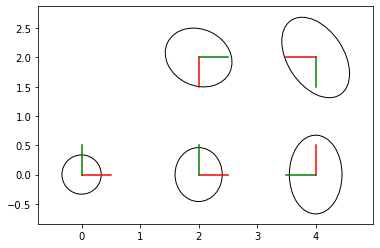

In [ ]:
# # Factor graph example 

# Helper function to create a pose
def vector3(x, y, z):
    """Create 3d double numpy array."""
    return np.array([x, y, z], dtype=np.float)

# Create noise model
priorNoise = gtsam.noiseModel_Diagonal.Sigmas(vector3(0.3, 0.3, 0.1))
model = gtsam.noiseModel_Diagonal.Sigmas(vector3(0.2, 0.2, 0.1))

# Instantiate the factor graph
example_graph = gtsam.NonlinearFactorGraph()

# Adding a prior on the first pose
example_graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), priorNoise))

# Create odometry (Between) factors between consecutive poses
example_graph.add(gtsam.BetweenFactorPose2( 1, 2, gtsam.Pose2(2, 0, 0), model)) 
example_graph.add(gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, math.pi / 2), model)) 
example_graph.add(gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, math.pi / 2), model)) 
example_graph.add(gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, math.pi / 2), model)) 

# Add the loop closure constraint
example_graph.add(gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, math.pi / 2), model)) 

# Create the initial estimate
example_initial_estimate = gtsam.Values()
example_initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
example_initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
example_initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
example_initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
example_initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))

# 4. Optimize the initial values using a Gauss-Newton nonlinear optimizer
ex_parameters = gtsam.GaussNewtonParams()
ex_parameters.setRelativeErrorTol(1e-5)
ex_parameters.setMaxIterations(100)
ex_optimizer = gtsam.GaussNewtonOptimizer(example_graph, example_initial_estimate, ex_parameters)
ex_result = ex_optimizer.optimize()
print("Final Result:\n{}".format(ex_result))

# Plot your graph
marginals = gtsam.Marginals(example_graph, ex_result)
fig = plt.figure(0)
for i in range(1, 6):
    gtsam_plot.plot_pose2(0, ex_result.atPose2(i), 0.5, marginals.marginalCovariance(i))

plt.axis('equal')
plt.show()

**TODO** [25 points]

You will be using your ICP implementation here to find the transform between two subsequent clouds. These transforms become the factors between pose variables in the graph. So, you will need to go through all the point clouds and run icp pair-wise to find the relative movement of the car. With these transformation, create a factor representing the transform between the pose variables.

We talked about how loop closure helps us consolidate conflicting data into a better global estimate. Unfortunately, our car does not perform a loop closure. So, our graph would just be a long series of poses connected by icp-returned transforms. However, our lidar scans are noisy, which means that our icp-returned transforms are not perfect either. This ultimately results in incorrect vehicle poses and overall map. One way that we can augment our graph is through "skipping". We simply run ICP between every other cloud, and add these skip connections into the graph. You can basically perform ICP between two non-consecutive point clouds and add that transform as a factor in the factor graph.

In [ ]:
def populate_factor_graph(graph, initial_estimates, initial_pose, clouds):
    """Populates a gtsam.NonlinearFactorGraph with
    factors between state variables. Populates
    initial_estimates for state variables as well.

    Args:
        graph (gtsam.NonlinearFactorGraph): the factor graph populated with ICP constraints
        initial_estimates (gtsam.Values):   the populated estimates for vehicle poses
        initial_pose (gtsam.Pose3):         the starting pose for the estimates in world coordinates
        clouds (np.ndarray):                the numpy array with all our point clouds
    """
    ICP_NOISE = gtsam.noiseModel_Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
    factor_pose = initial_pose

    # Add ICP Factors between each pair of clouds
    prev_T = gtsam.Pose3()
    for i in range(len(clouds) - 1):
        # TODO: Run ICP between clouds (hint: use inital_tranform argument)
        T, icp_series = icp(clouds[i], clouds[i+1], initial_transform=prev_T)
        #prev_T = T

        # TODO: Set T to its inverse: use `gtsam.Pose3.inverse()`
        T = T.inverse()
        prev_T = T

        # TODO: Add a `gtsam.BetweenFactorPose3()` to the graph
        graph.add( gtsam.BetweenFactorPose3( i, i + 1, T, ICP_NOISE ) )

        factor_pose = factor_pose.compose(T)
        initial_estimates.insert(i+1, factor_pose)
        print(".", end="")

    # Add skip connections between every other frame
    prev_T = gtsam.Pose3()
    for i in range(0, len(clouds) - 2, 2):
        # TODO: Run ICP between clouds (hint: use inital_tranform argument)
        T, icp_series = icp(clouds[i], clouds[i+2], initial_transform=prev_T)
        #prev_T = T

        # TODO: Set T to its inverse: use `gtsam.Pose3.inverse()`
        T = T.inverse()
        prev_T = T

        # TODO: Add a `gtsam.BetweenFactorPose3()` to the graph
        graph.add( gtsam.BetweenFactorPose3( i, i + 2, T, ICP_NOISE ) )

        print(".", end="")

    print("\n Done")
    return graph, initial_estimates

The real power of GTSAM will show here. In five lines, we'll setup a Gauss Newton nonlinear optimizer and optimize for the vehicle's poses in world coordinates.

Note: This cell runs your ICP implementation 180 times. If you've implemented your ICP similarly to the TAs, expect this cell to take 2 minutes. If you're missing the `initial_transform` argument for icp, it may take ~1 hour.

In [ ]:
# load in all clouds in our dataset
clouds = read_ply(*scans_fnames)

# Setting up our factor graph
graph = gtsam.NonlinearFactorGraph()
initial_estimates = gtsam.Values()

# We get the initial pose of the car from Argo AI's dataset, and we add it to the graph as such
PRIOR_NOISE = gtsam.noiseModel_Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
initial_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                           gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))
graph.add(gtsam.PriorFactorPose3(0, initial_pose, PRIOR_NOISE))
initial_estimates.insert(0, initial_pose)

# We'll use your function to populate the factor graph
graph, initial_estimates = populate_factor_graph(graph, initial_estimates, initial_pose, clouds)

# Now optimize for the states
parameters = gtsam.GaussNewtonParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(100)
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimates, parameters)
result = optimizer.optimize()

............................................................................................................................................................................................................................................................................
 Done


Let's plot these poses to see how our vechicle moves.

Screenshot this for your reflection.

In [ ]:
poses_cloud = np.array([[], [], []])
for i in range(len(clouds)):
    poses_cloud = np.hstack([poses_cloud, np.array([[result.atPose3(i).x()], [result.atPose3(i).y()], [result.atPose3(i).z()]])])

init_car_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                            gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))
visualize_clouds([poses_cloud, transform_cloud(init_car_pose, clouds[0])], show_grid_lines=True)

Output hidden; open in https://colab.research.google.com to view.

These unit tests will verify the basic functionality of the function you've implemented in this section. Keep in mind that these are not exhaustive.

In [ ]:
import unittest

class TestFactorGraph(unittest.TestCase):

    def setUp(cls):
      test_clouds = read_ply(*scans_fnames)[:6]
      PRIOR_NOISE = gtsam.noiseModel_Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
      ICP_NOISE = gtsam.noiseModel_Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
      test_graph = gtsam.NonlinearFactorGraph()
      test_initial_estimates = gtsam.Values()
      initial_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                          gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))
      test_graph.add(gtsam.PriorFactorPose3(0, initial_pose, PRIOR_NOISE))
      test_initial_estimates.insert(0, initial_pose)
      test_graph, test_initial_estimates = populate_factor_graph(test_graph, test_initial_estimates, initial_pose, test_clouds)
      cls.graph = test_graph
      cls.initial_estimates = test_initial_estimates
    
    def test_graph_params(self):
      self.assertTrue(type(self.graph) == gtsam.NonlinearFactorGraph)
    
    def test_initial_estimates_params(self):
      self.assertTrue(type(self.initial_estimates) == gtsam.Values)

def suite():
  functions = ['test_graph_params', 'test_initial_estimates_params']
  suite = unittest.TestSuite()
  for func in functions:
    suite.addTest(TestFactorGraph(func))
  return suite
    
if __name__ == "__main__":
    runner = unittest.TextTestRunner()
    runner.run(suite())

......

.

.
 Done
......

.

.
 Done



----------------------------------------------------------------------
Ran 2 tests in 68.311s

OK


# Mapping

In this section, we'll tackle the mapping component of SLAM (Simulataneous Localization and Mapping). The previous section used a factor graph to localize our vehicle's poses in world coordinates. We'll now use those poses to form a map of the street from the point clouds.

Given the poses and the clouds, this task is easy. We'll use your `transform_cloud` method from the ICP section to transform every other cloud in our dataset to be centered at the corresponding pose where the cloud was captured. Visualizing all of these clouds yields the complete map. We don't use every cloud in our dataset to reduce the amount of noise in our map while retaining plenty of detail.

Screenshot this for your reflection.

In [ ]:
cloud_map = []
for i in range(0, len(clouds), 2):
    cloud_map.append(transform_cloud(result.atPose3(i), clouds[i-1]))

visualize_clouds(cloud_map, show_grid_lines=True, single_color="#C6C6C6")

Output hidden; open in https://colab.research.google.com to view.

# Reflection

Complete the reflection questions in the proj6_report_template.pptx, which you can find in the files tab on Canvas. Failure to follow the format will be penalized. Save the report as a .pdf and rename it to "FIRSTNAME_LASTNAME_reflection.pdf".

### Rubric

 * 25 points: ICP Section
 * 25 points: Factor Graph Section
 * 0 points: Mapping Section (questions in reflection)
 * 50 points: Reflection

### Submission Details

Deliverables are a zip file named "FIRSTNAME_LASTNAME_project6.zip" with the following files:

 * project6.py - exported from Google Colab
 * FIRSTNAME_LASTNAME_reflection.pdf - exported from the given powerpoint

This is an individual assignment, everyone should submit their own files.

